<a href="https://colab.research.google.com/github/WafryAhamed/Artistic_Pixels_Report/blob/main/Copy_of_ModelTraining2_Keran.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 0


Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Define paths to Excel files in Google Drive
train_path = '/content/drive/My Drive/train_data.xlsx'
val_path = '/content/drive/My Drive/val_data.xlsx'

Load Train & Validation Data from Google Drive

In [ ]:
import pandas as pd

# Load into DataFrames
train_df = pd.read_excel(train_path)
val_df = pd.read_excel(val_path)

# Preview shapes
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)


Train shape: (704, 5)
Validation shape: (151, 5)


Split Features and Target

In [ ]:
# Define your final selected feature columns and target
feature_cols = ['QuizAverage', 'StudyEfficiency', 'ParticipationScore', 'AssignmentPenaltyScore']
target_col = 'EncodedGrade'

# Split features (X) and target (y)
X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_val = val_df[feature_cols]
y_val = val_df[target_col]

# Preview shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (704, 4)
y_train shape: (704,)
X_val shape: (151, 4)
y_val shape: (151,)


In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 18.4 MB/s eta 0:00:00


Increased to 3 hidden layers - Learn more complx patterns
Batch size added


In [ ]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

def objective(trial):
    # Suggest hyperparameters
    neurons1 = trial.suggest_int('neurons1', 64, 256, step=32)
    neurons2 = trial.suggest_int('neurons2', 64, 256, step=32)
    neurons3 = trial.suggest_int('neurons3', 32, 128, step=16)  # Extra layer
    dropout1 = trial.suggest_float('dropout1', 0.2, 0.5)
    dropout2 = trial.suggest_float('dropout2', 0.2, 0.5)
    dropout3 = trial.suggest_float('dropout3', 0.1, 0.4)
    learning_rate = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])

    # Build model
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(neurons1, activation='relu'),
        Dropout(dropout1),
        Dense(neurons2, activation='relu'),
        Dropout(dropout2),
        Dense(neurons3, activation='relu'),
        Dropout(dropout3),
        Dense(4, activation='softmax')  # 4 classes
    ])

    # Select optimizer
    optimizer = Adam(learning_rate) if optimizer_name == 'adam' else RMSprop(learning_rate)

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss=SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # Get final validation accuracy and loss
    val_acc = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1]

    # Store loss to review later
    trial.set_user_attr("val_loss", val_loss)

    return val_acc


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # You can try 50–100 for best tuning

# Results
print("✅ Best Validation Accuracy:", study.best_value)
print("📌 Best Hyperparameters:", study.best_params)
print("📉 Best Validation Loss:", study.best_trial.user_attrs["val_loss"])


[I 2025-08-27 03:44:47,028] A new study created in memory with name: no-name-65ac6db3-26a9-4903-9a3f-7df74cb17c24
[I 2025-08-27 03:44:55,719] Trial 0 finished with value: 0.251655638217926 and parameters: {'neurons1': 192, 'neurons2': 256, 'neurons3': 32, 'dropout1': 0.4436568739820992, 'dropout2': 0.2563779660932272, 'dropout3': 0.26275561139936643, 'lr': 0.0048414186867467525, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.251655638217926.
[I 2025-08-27 03:45:04,914] Trial 1 finished with value: 0.29139071702957153 and parameters: {'neurons1': 64, 'neurons2': 224, 'neurons3': 80, 'dropout1': 0.3721177202385173, 'dropout2': 0.25916216414688387, 'dropout3': 0.3092086025084437, 'lr': 0.00016408053042309164, 'optimizer': 'adam'}. Best is trial 1 with value: 0.29139071702957153.
[I 2025-08-27 03:45:12,406] Trial 2 finished with value: 0.6490066051483154 and parameters: {'neurons1': 256, 'neurons2': 128, 'neurons3': 128, 'dropout1': 0.24740220607953933, 'dropout2': 0.30776213954059

✅ Best Validation Accuracy: 0.7682119011878967
📌 Best Hyperparameters: {'neurons1': 160, 'neurons2': 256, 'neurons3': 112, 'dropout1': 0.4971040078542302, 'dropout2': 0.4685202850062184, 'dropout3': 0.22702217262578847, 'lr': 0.004014683976030666, 'optimizer': 'rmsprop'}
📉 Best Validation Loss: 0.8399307131767273


Batch normaliztion (Helps stabilize training, speed up convergence, and prevent overfitting)

EarlyStopping stops training when val_loss stops improving, avoiding unnecessary overfitting

ReduceLROnPlateau lowers learning rate if validation loss stagnates, helping the optimizer fine-tune (Alpha)

In [ ]:
# Extract best parameters from Optuna
best_params = study.best_params

neurons1 = best_params['neurons1']
neurons2 = best_params['neurons2']
neurons3 = best_params['neurons3']
dropout1 = best_params['dropout1']
dropout2 = best_params['dropout2']
dropout3 = best_params['dropout3']
learning_rate = best_params['lr']
optimizer_name = best_params['optimizer']

# Define optimizer
from tensorflow.keras.optimizers import Adam, RMSprop
if optimizer_name == 'adam':
    optimizer = Adam(learning_rate=learning_rate)
else:
    optimizer = RMSprop(learning_rate=learning_rate)

# Build the final ANN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

final_model = Sequential([
    Input(shape=(X_train.shape[1],)),

    # First hidden layer
    Dense(neurons1, activation='relu'),
    BatchNormalization(),  # Helps stabilize training
    Dropout(dropout1),

    # Second hidden layer
    Dense(neurons2, activation='relu'),
    BatchNormalization(),
    Dropout(dropout2),

    # Third hidden layer
    Dense(neurons3, activation='relu'),
    BatchNormalization(),
    Dropout(dropout3),

    # Output layer
    Dense(4, activation='softmax')  # 4 classes: A, B, C, F
])

# Compile model
final_model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Train the model
final_history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # increased for more learning opportunity
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4228 - loss: 1.6428 - val_accuracy: 0.2450 - val_loss: 15.0086 - learning_rate: 0.0040
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5328 - loss: 1.1779 - val_accuracy: 0.2252 - val_loss: 6.6067 - learning_rate: 0.0040
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6776 - loss: 0.8591 - val_accuracy: 0.2980 - val_loss: 5.8167 - learning_rate: 0.0040
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6940 - loss: 0.7883 - val_accuracy: 0.4040 - val_loss: 3.4232 - learning_rate: 0.0040
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6123 - loss: 0.8901 - val_accuracy: 0.6490 - val_loss: 0.8244 - learning_rate: 0.0040
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6877 - loss: 0.7388 - val_accuracy: 0.6291 - val_loss: 0.9797 - learning_rate: 0.0040
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6403 - loss: 0.7948 - val_accuracy

In [ ]:
# Load the test set from Excel
test_df = pd.read_excel("/content/drive/MyDrive/test_data.xlsx")

# Define features and target
feature_cols = ['QuizAverage', 'StudyEfficiency', 'ParticipationScore', 'AssignmentPenaltyScore']
target_col = 'EncodedGrade' # Corrected target column name

X_test = test_df[feature_cols]
y_test = test_df[target_col]

# Preview
print("Test shape:", X_test.shape)

Test shape: (152, 4)


In [ ]:
# Evaluate model on test data
test_loss, test_accuracy = final_model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")
print(f"📉 Test Loss: {test_loss:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8663 - loss: 0.3946 

✅ Test Accuracy: 0.8553
📉 Test Loss: 0.4007


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
📄 Classification Report:
              precision    recall  f1-score   support

           A       0.82      0.87      0.85        38
           B       0.74      0.82      0.78        38
           C       0.94      0.76      0.84        38
           F       0.95      0.97      0.96        38

    accuracy                           0.86       152
   macro avg       0.86      0.86      0.86       152
weighted avg       0.86      0.86      0.86       152



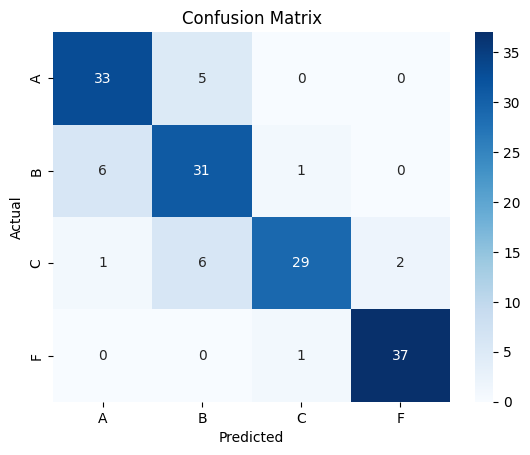

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict classes
y_pred_probs = final_model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

# Classification Report
print("📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["A", "B", "C", "F"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["A", "B", "C", "F"], yticklabels=["A", "B", "C", "F"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Save model to Google Drive
final_model.save("/content/drive/MyDrive/model2.h5")
print("✅ Model saved to Google Drive.")


✅ Model saved to Google Drive.


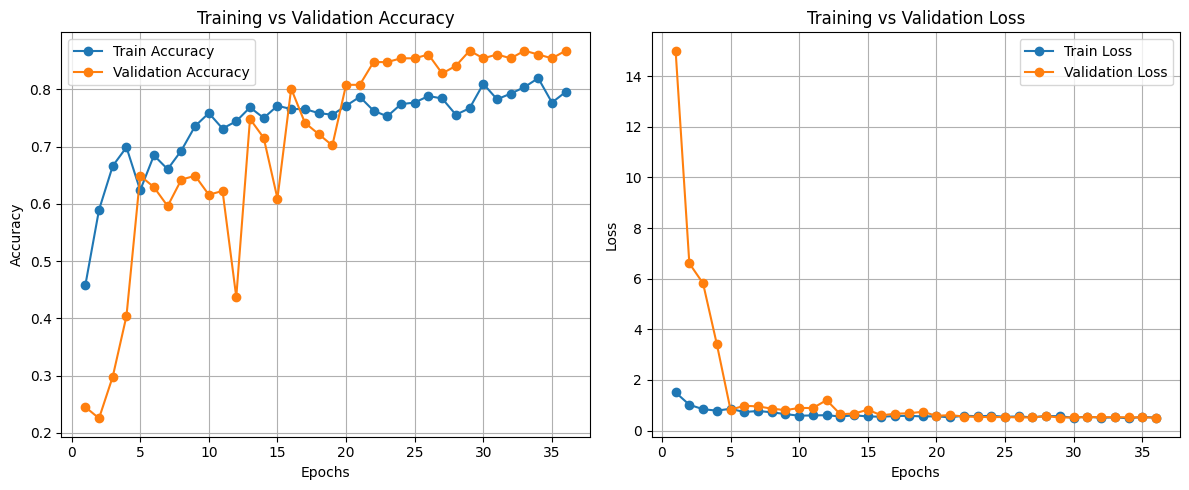

In [ ]:
import matplotlib.pyplot as plt

# Get accuracy and loss from history
acc = final_history.history['accuracy']
val_acc = final_history.history['val_accuracy']
loss = final_history.history['loss']
val_loss = final_history.history['val_loss']

# Define number of epochs
epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


2nd